# <ins>Predicting Poetic Movements</ins>

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)

    - [Parameter tuning](#Parameter-tuning)
    - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

In this notebook, I will create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [4]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Multicollinearity

[[go back to the top](#Predicting-Poetic-Movements)]

In [5]:
# list of continuous variables
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

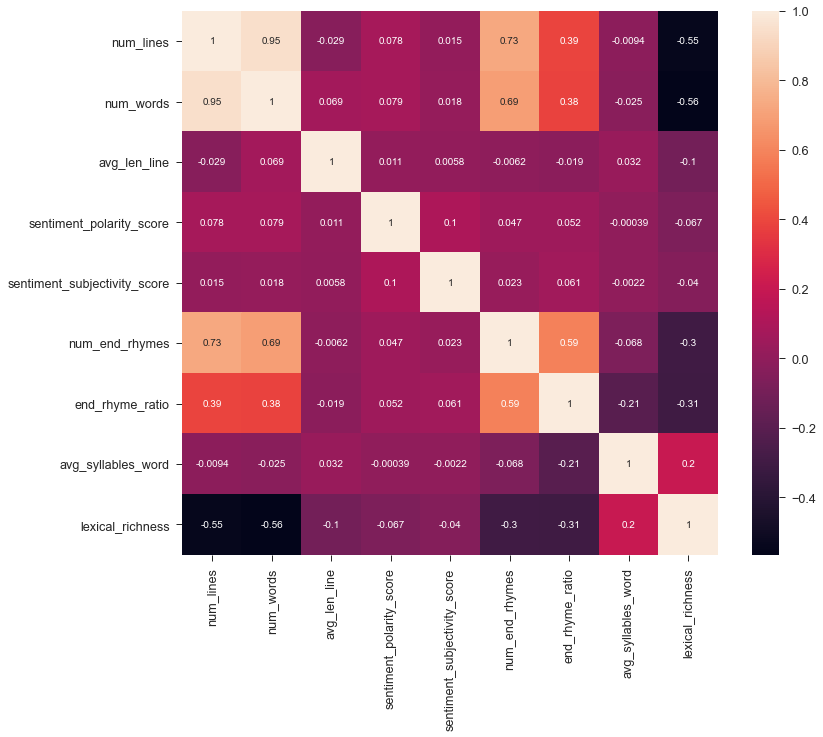

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- As seen in the [previous notebook](03_nlp_features_eda.ipynb), the number of lines (```num_lines```) and number of words (```num_words```) in a poem are very highly correlated.
    - I'll drop ```num_words```, as the number of lines is a more widely used metric for the length of a poem.
- The number of end rhymes (```num_end_rhymes```) is also rather highly correlated with ```num_lines```, so it's worth considering dropping that.
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [7]:
# new list of continuous variables
cont_cols = [
    'num_lines', 'avg_len_line', 'sentiment_polarity_score', 
    'sentiment_subjectivity_score', 'end_rhyme_ratio', 
    'avg_syllables_word', 'lexical_richness'
]

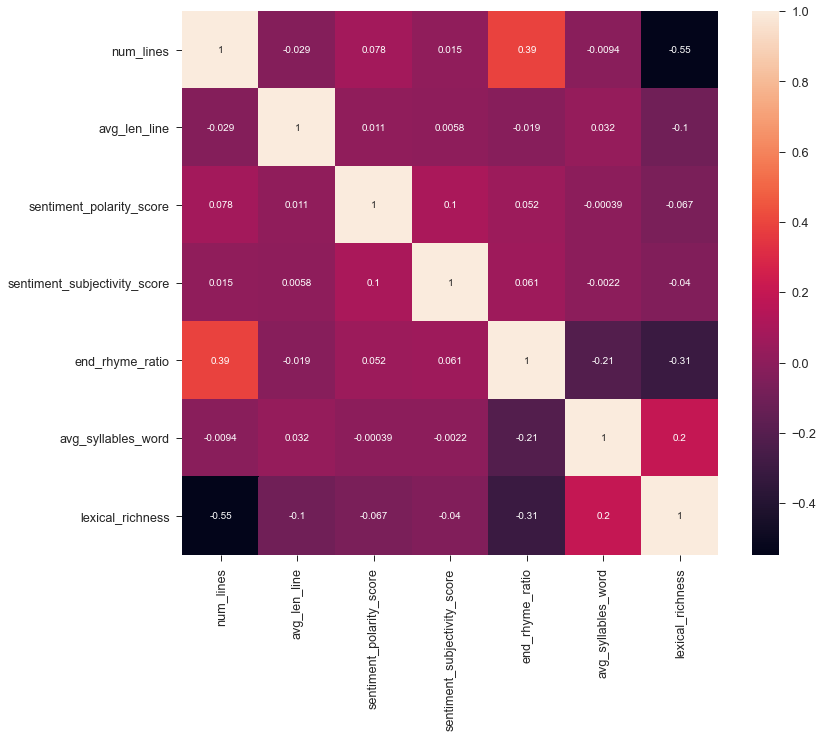

In [8]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Predicting-Poetic-Movements)]

- Cap or floor outlier values as necessary.

In [9]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [10]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_lines                       7.000000
avg_len_line                    3.346818
sentiment_polarity_score       -0.970270
sentiment_subjectivity_score    0.257885
end_rhyme_ratio                 0.000000
avg_syllables_word              1.092393
lexical_richness                0.440678
Name: 0.05, dtype: float64
------------------------------------------
num_lines                       131.700000
avg_len_line                      9.750000
sentiment_polarity_score          0.995900
sentiment_subjectivity_score      0.687500
end_rhyme_ratio                   1.009091
avg_syllables_word                1.372212
lexical_richness                  0.850402
Name: 0.95, dtype: float64


#### Number of lines

In [11]:
# descriptive stats
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

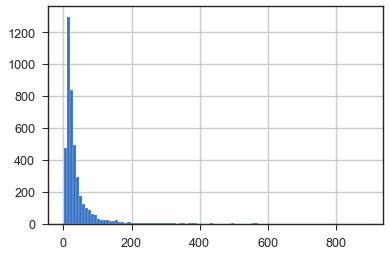

In [12]:
# current distribution
df.num_lines.hist(bins=100);

In [13]:
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])

# descriptive stats
df_capped['num_lines'].describe()

count    4307.000000
mean       34.295147
std        31.983861
min         7.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       131.700000
Name: num_lines, dtype: float64

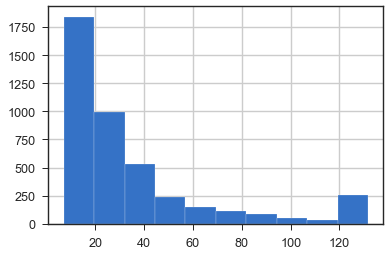

In [14]:
# new distribution
df_capped.num_lines.hist();

#### Average words per line

In [15]:
# descriptive stats
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

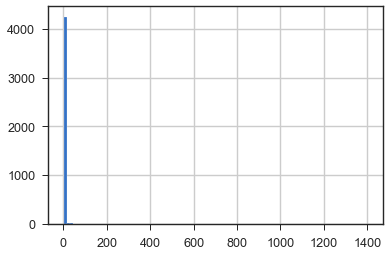

In [16]:
# current distribution
df.avg_len_line.hist(bins=100);

In [17]:
# cap/floor outliers
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])

# descriptive stats
df_capped['avg_len_line'].describe()

count    4307.000000
mean        6.494119
std         1.721049
min         3.346818
25%         5.260870
50%         6.527778
75%         7.714286
max         9.750000
Name: avg_len_line, dtype: float64

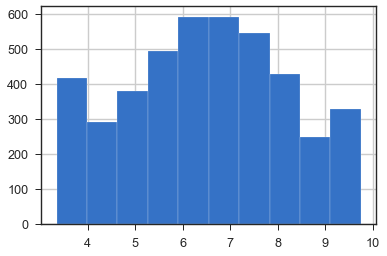

In [18]:
# new distribution
df_capped.avg_len_line.hist();

#### End rhyme ratio

In [19]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

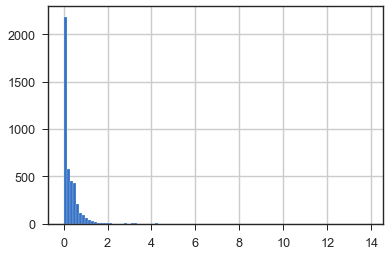

In [20]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [21]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4307.000000
mean        0.254074
std         0.293332
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max         1.009091
Name: end_rhyme_ratio, dtype: float64

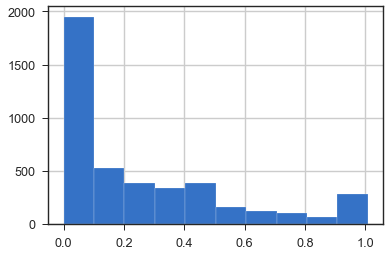

In [22]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [23]:
# descriptive stats
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

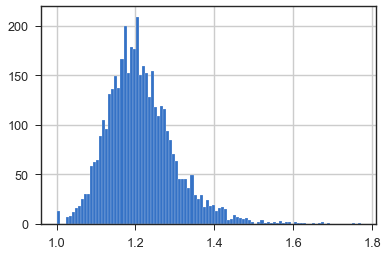

In [24]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [25]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4307.000000
mean        1.212364
std         0.075228
min         1.092393
25%         1.155752
50%         1.204545
75%         1.261905
max         1.372212
Name: avg_syllables_word, dtype: float64

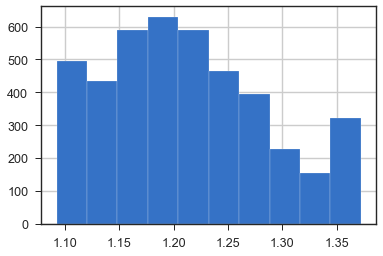

In [26]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [27]:
# descriptive stats
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

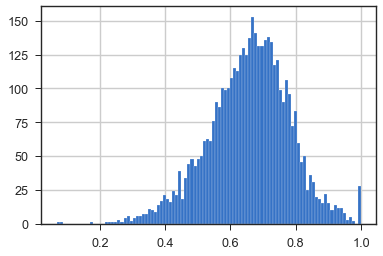

In [28]:
# current distribution
df.lexical_richness.hist(bins=100);

In [29]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4307.000000
mean        0.658047
std         0.111326
min         0.440678
25%         0.580302
50%         0.666667
75%         0.740260
max         0.850402
Name: lexical_richness, dtype: float64

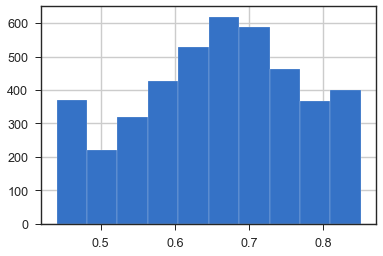

In [30]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [31]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

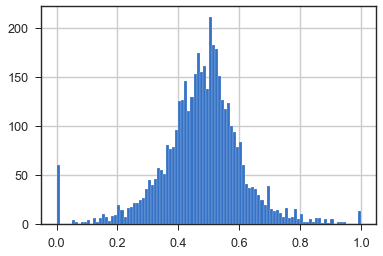

In [32]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [33]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4307.000000
mean        0.479417
std         0.109112
min         0.257885
25%         0.410284
50%         0.484470
75%         0.550000
max         0.687500
Name: sentiment_subjectivity_score, dtype: float64

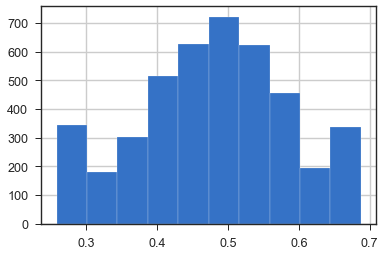

In [34]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [35]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df_capped.pkl', 'wb') as goodbye:
#     pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
#     df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Predicting-Poetic-Movements)]

- Create features DataFrame and target series. 
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    
#### Features and target

In [36]:
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness', 
     'string_cleaned']
]

# assign target variable
y = df_capped['movement']

In [37]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [38]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_cleaned')
X_test_nums = X_test.drop(columns='string_cleaned')

In [39]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [40]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

CPU times: user 466 ms, sys: 7.04 ms, total: 473 ms
Wall time: 472 ms


In [41]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 17 s, sys: 75.6 ms, total: 17 s
Wall time: 17.1 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [42]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

# Step 2: Modeling

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters.
- Finally, I can train and save a final model.


----------------------------

- Because the dataset is so large (in both rows and columns) and cross-validation is so intensive, we are only able to use train-test split to cross-validate.


## Baseline model

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [43]:
%%time

# instantiate the naive bayes classifier
benaba_vec = BernoulliNB()

# fit it to our training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 4.02 s, sys: 479 ms, total: 4.5 s
Wall time: 4.15 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [44]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_preds_bnb_vec = benaba_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
benaba_vec_acc_train = accuracy_score(y_train, y_train_preds_bnb_vec)
benaba_vec_f1_train = f1_score(y_train, y_train_preds_bnb_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_vec_acc_train}')
print(f'F1 score: {benaba_vec_f1_train}')

# print out accuracy and f1 scores for test set
benaba_vec_acc_test = accuracy_score(y_test, y_test_preds_bnb_vec)
benaba_vec_f1_test = f1_score(y_test, y_test_preds_bnb_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_vec_acc_test}')
print(f'F1 score: {benaba_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_vec))

-----TRAIN-----
Accuracy: 0.6575851393188854
F1 score: 0.662223098170161

-----TEST-----
Accuracy: 0.4428969359331476
F1 score: 0.41395254927457104

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.62      0.12      0.20       239
 avant_garde       0.65      0.33      0.44       268
      modern       0.35      0.84      0.49       311
    pre_1900       0.70      0.38      0.49       259

    accuracy                           0.44      1077
   macro avg       0.58      0.42      0.41      1077
weighted avg       0.57      0.44      0.41      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 29  28 175   7]
 [ 14  88 158   8]
 [  4  18 261  28]
 [  0   2 158  99]]
CPU times: user 6.3 s, sys: 721 ms, total: 7.02 s
Wall time: 5.74 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [45]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
aalto, nibbed, nib, niagara, nhat, nguin, ngorongoro, nglish, nghe, nez

Avant-Garde tweets:
zwim, scaut, scaur, gullied, scauld, scaul, scaud, scatterd, scathing, scath

Modern tweets:
aalto, morituri, morison, moribund, moriartys, moreton, moren, morello, mordecai, mormorio

Pre-1900 tweets:
aalto, halidom, halios, santo, hallelujah, santit, hallmark, halloing, santa, hallooed



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

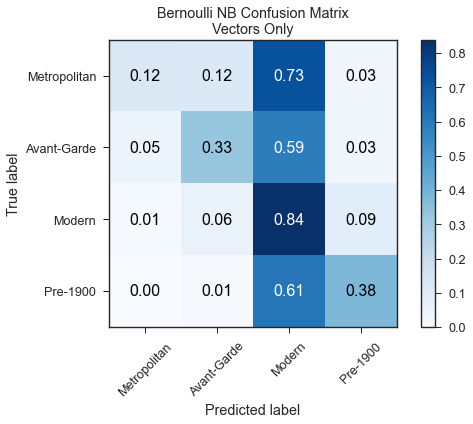

In [46]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_test_preds_bnb_vec)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [47]:
%%time

# instantiate the naive bayes classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 8.54 s, sys: 1.54 s, total: 10.1 s
Wall time: 9.84 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [48]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_combo = benaba_combo.predict(X_train_combo)
y_test_preds_bnb_combo = benaba_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
benaba_combo_acc_train = accuracy_score(y_train, y_train_preds_bnb_combo)
benaba_combo_f1_train = f1_score(y_train, y_train_preds_bnb_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_combo_acc_train}')
print(f'F1 score: {benaba_combo_f1_train}')

# print out accuracy and f1 scores for test set
benaba_combo_acc_test = accuracy_score(y_test, y_test_preds_bnb_combo)
benaba_combo_f1_test = f1_score(y_test, y_test_preds_bnb_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_combo_acc_test}')
print(f'F1 score: {benaba_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_combo))

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6685623743394035

-----TEST-----
Accuracy: 0.4503249767873723
F1 score: 0.4264836594564233

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.65      0.15      0.25       239
 avant_garde       0.65      0.33      0.44       268
      modern       0.35      0.84      0.49       311
    pre_1900       0.70      0.38      0.49       259

    accuracy                           0.45      1077
   macro avg       0.59      0.43      0.42      1077
weighted avg       0.58      0.45      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 37  28 167   7]
 [ 15  89 157   7]
 [  5  18 260  28]
 [  0   2 158  99]]
CPU times: user 12.2 s, sys: 2.15 s, total: 14.4 s
Wall time: 13.2 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

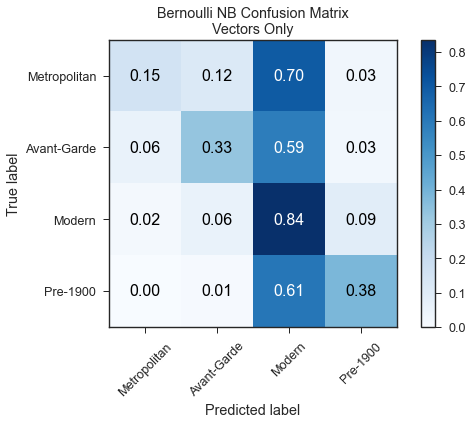

In [49]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_bnb_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This confirms it is practically the same, with a slightly better accuracy at predicting Metropolitan.

#### Feature importances

In [50]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
leeward, niagara, nhat, nguin, ngorongoro, nglish, nghe, nez, nex, newtown

Avant-Garde tweets:
leeward, monian, monhegan, mongst, mongrel, mongoose, mongolian, mong, mondo, monde

Modern tweets:
leeward, morison, moribund, moriartys, moreton, moren, morello, mordecai, moralistic, morituri

Pre-1900 tweets:
grincait, irving, irritation, irritable, irrigation, irrigate, irrevocable, irreversibl, irretrievably, irretrievables



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [51]:
%%time

# instantiate decision tree classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

# fit them to the training set and evaluate
cv_scores_knn_vec = cross_val_score(
    knn_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_knn_combo = cross_val_score(
    knn_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_knn_vec}')
print(f'Average score: {np.mean(cv_scores_knn_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_knn_combo}')
print(f'Average score: {np.mean(cv_scores_knn_combo)}\n')

-----Vectors only-----
All scores: [0.45549181 0.48010828 0.40762273 0.52430862 0.41714101 0.46658148
 0.40206746 0.44194881 0.49727948 0.41709663]
Average score: 0.4509646304969624

------Vectors + Numerical Data-----
All scores: [0.54448047 0.51639483 0.52337022 0.56402105 0.53402214 0.53691744
 0.51938092 0.52058681 0.52834179 0.52834396]
Average score: 0.5315859631347133

CPU times: user 3min 39s, sys: 6.59 s, total: 3min 46s
Wall time: 9min 32s


- This performs better than the Naive Bayes model, and the combo data set is far better than vectors only.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

100%|██████████| 25/25 [27:31<00:00, 66.04s/it]


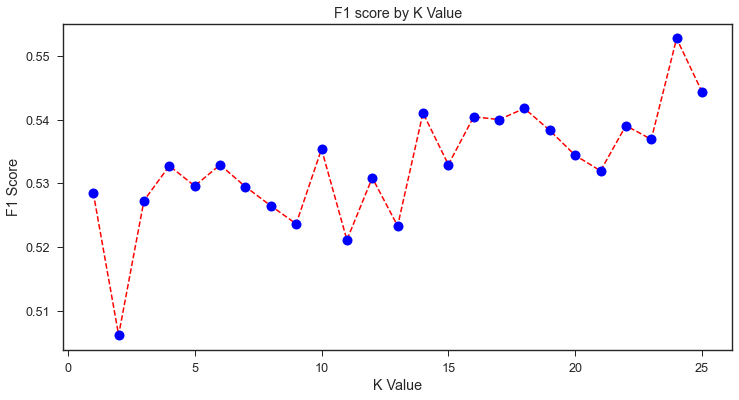

CPU times: user 2h 22min 26s, sys: 1min 32s, total: 2h 23min 58s
Wall time: 27min 31s


In [53]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
k_range = list(range(1, 26))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [65]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(24, 0.5527301128264127),
 (25, 0.5443611441514613),
 (18, 0.5417521422544705),
 (14, 0.5410371366292553),
 (16, 0.5404437241623725)]

- *k=24* appears to have the best results, so I'll train a model on that.

In [68]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=24, 
    p=2, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 12.9 s, sys: 1.81 s, total: 14.7 s
Wall time: 14.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                     weights='uniform')

In [69]:
%%time

# predict class for the train and test sets
y_train_preds_knn_combo = knn_combo.predict(X_train_combo)
y_test_preds_knn_combo = knn_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
knn_combo_acc_train = accuracy_score(y_train, y_train_preds_knn_combo)
knn_combo_f1_train = f1_score(y_train, y_train_preds_knn_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {knn_combo_acc_train}')
print(f'F1 score: {knn_combo_f1_train}')

# print out accuracy and f1 scores for test set
knn_combo_acc_test = accuracy_score(y_test, y_test_preds_knn_combo)
knn_combo_f1_test = f1_score(y_test, y_test_preds_knn_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {knn_combo_acc_test}')
print(f'F1 score: {knn_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_knn_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_knn_combo))

-----TRAIN-----
Accuracy: 0.595046439628483
F1 score: 0.5891827210046805

-----TEST-----
Accuracy: 0.5598885793871866
F1 score: 0.5527301128264127

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.62      0.58       239
 avant_garde       0.55      0.48      0.51       268
      modern       0.48      0.40      0.44       311
    pre_1900       0.66      0.78      0.71       259

    accuracy                           0.56      1077
   macro avg       0.56      0.57      0.56      1077
weighted avg       0.55      0.56      0.55      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[149  43  40   7]
 [ 69 128  53  18]
 [ 55  53 125  78]
 [  5  10  43 201]]
CPU times: user 22min 2s, sys: 7.92 s, total: 22min 10s
Wall time: 3min 21s


#### Confusion matrix

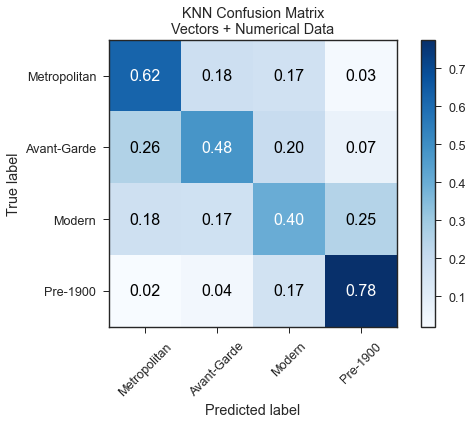

In [70]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_knn_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='KNN Confusion Matrix\nVectors + Numerical Data', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/knn_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Metropolitan, which is interesting. Perhaps this genre is quite clustered.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Modern and Avant-Garde.
    
- Very decent fit.

## Decision Tree

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: This will take a few minutes to run.

In [77]:
%%time

# instantiate decision tree classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

# fit them to the training set and evaluate
cv_scores_tree_vec = cross_val_score(
    tree_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_tree_combo = cross_val_score(
    tree_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_tree_vec}')
print(f'Average score: {np.mean(cv_scores_tree_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_tree_combo}')
print(f'Average score: {np.mean(cv_scores_tree_combo)}\n')

-----Vectors only-----
All scores: [0.38359247 0.35297356 0.42890261 0.35097098 0.41296087 0.36372053
 0.3736484  0.39082299 0.43215202 0.39187787]
Average score: 0.38816222948811513

------Vectors + Numerical Data-----
All scores: [0.42174012 0.4520343  0.4456421  0.45588187 0.44062612 0.45471727
 0.45237006 0.48405022 0.48016292 0.44312837]
Average score: 0.45303533500125387

CPU times: user 3min 11s, sys: 3.83 s, total: 3min 14s
Wall time: 4min 34s


- Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain that using Random Forest, however.

## Random Forest

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

⏰ NOTE: This will take a several minutes to run.

In [ ]:
%%time

# instantiate random forest classifiers
forest_vec = RandomForestClassifier()
forest_combo = RandomForestClassifier()

# fit them to the training set and evaluate
cv_scores_forest_vec = cross_val_score(
    forest_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_forest_combo = cross_val_score(
    forest_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_forest_vec}')
print(f'Average score: {np.mean(cv_scores_forest_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_forest_combo}')
print(f'Average score: {np.mean(cv_scores_forest_combo)}\n')

- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [56]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 19.1 s, sys: 1.18 s, total: 20.2 s
Wall time: 20.3 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [57]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.5970287836583101
F1 score: 0.5937538585492644

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.59      0.50      0.54       239
 avant_garde       0.60      0.44      0.51       268
      modern       0.49      0.64      0.56       311
    pre_1900       0.75      0.80      0.77       259

    accuracy                           0.60      1077
   macro avg       0.61      0.59      0.60      1077
weighted avg       0.60      0.60      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[119  44  69   7]
 [ 49 119  89  11]
 [ 32  30 199  50]
 [  0   6  47 206]]
CPU times: user 7.34 s, sys: 1.52 s, total: 8.87 s
Wall time: 8.88 s


#### Confusion matrix

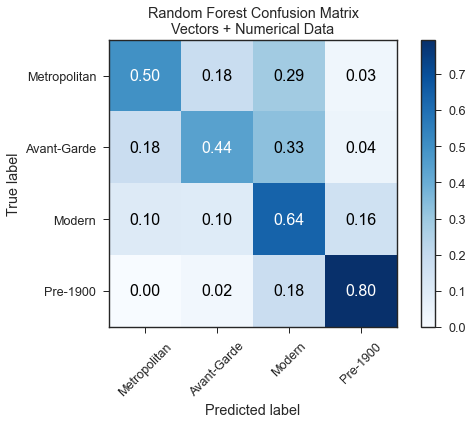

In [58]:
# plot confusion matrix - normalized
cm_forest = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm_forest, classes, normalize=True,
                      title='Random Forest Confusion Matrix\nVectors + Numerical Data', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rf_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- Big strides made on all categories here.
- Looks like some improvement could be made for Avant-Garde and Metropolitan poetries.
- Very overfit.

#### Feature importances

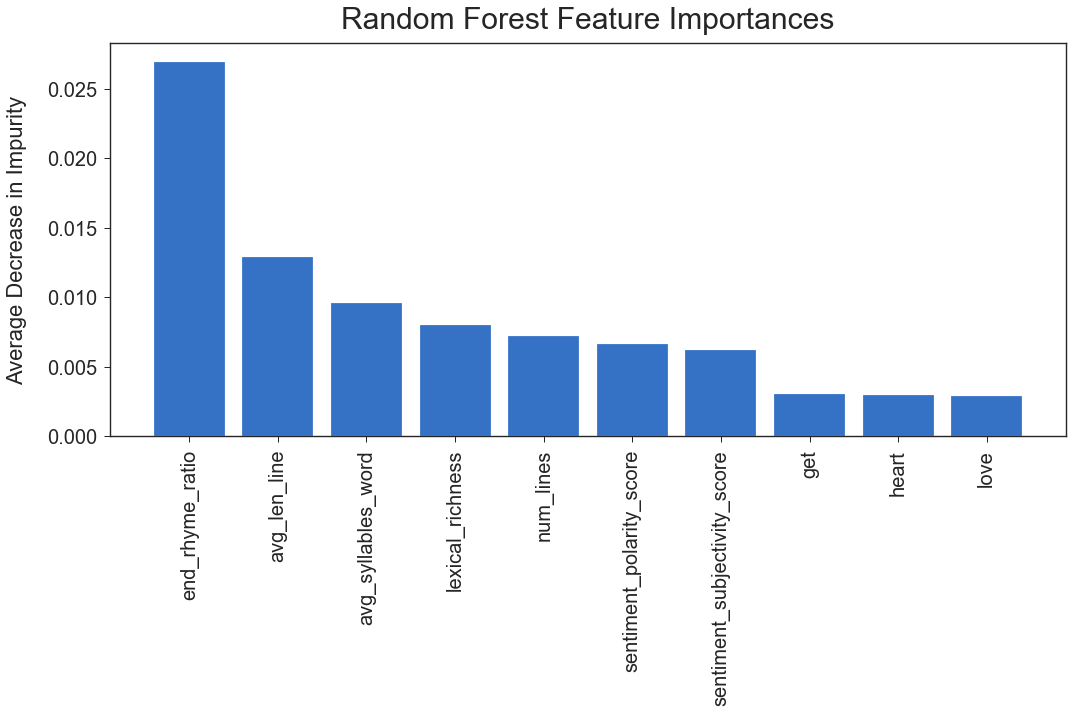





[('end_rhyme_ratio', 0.0269099540621554), ('avg_len_line', 0.012858978340824277), ('avg_syllables_word', 0.00958490207364689), ('lexical_richness', 0.007973807580554713), ('num_lines', 0.007185716681905299), ('sentiment_polarity_score', 0.006632256696121029), ('sentiment_subjectivity_score', 0.0062189066416924324), ('get', 0.0029982682122782606), ('heart', 0.0029750799151060455), ('love', 0.0028855694578546576)]


In [59]:
plot_forest_features(
    forest_combo, 
    X_train_combo)

- Mostly engineered features here, and some surprise words.

## SVM

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: Next cell took me 1 hour and 9 minutes to run.

In [60]:
%%time

# instantiate random forest classifiers
svm_vec = SVC(kernel='linear')
svm_combo = SVC(kernel='linear')

# fit them to the training set and evaluate
cv_scores_svm_vec = cross_val_score(
    svm_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_combo = cross_val_score(
    svm_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_vec}')
print(f'Average score: {np.mean(cv_scores_svm_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_combo}')
print(f'Average score: {np.mean(cv_scores_svm_combo)}\n')

-----Vectors only-----
All scores: [0.57162223 0.65635489 0.56057759 0.60033056 0.596614   0.61479061
 0.5940823  0.60793209 0.62537091 0.55219607]
Average score: 0.5979871245353284

------Vectors + Numerical Data-----
All scores: [0.62463016 0.65362662 0.61669224 0.63429354 0.61232149 0.62227621
 0.60247644 0.64619977 0.65761514 0.59831745]
Average score: 0.6268449045483155

CPU times: user 4min 52s, sys: 8.69 s, total: 5min
Wall time: 1h 9min 5s


### Vectors + numerical data

⏰ NOTE: Next cell took me 10 minutes to run.

In [62]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 9min 39s, sys: 2.83 s, total: 9min 42s
Wall time: 9min 43s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

⏰ NOTE: Next cell took me 10 minutes to run.

In [63]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9702786377708978
F1 score: 0.9702470350138073

-----TEST-----
Accuracy: 0.627669452181987
F1 score: 0.6273528663085168

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.57      0.52      0.54       239
 avant_garde       0.59      0.56      0.57       268
      modern       0.54      0.61      0.57       311
    pre_1900       0.83      0.83      0.83       259

    accuracy                           0.63      1077
   macro avg       0.63      0.63      0.63      1077
weighted avg       0.63      0.63      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[124  51  58   6]
 [ 44 149  66   9]
 [ 47  45 189  30]
 [  4   7  34 214]]
CPU times: user 9min 11s, sys: 3.92 s, total: 9min 15s
Wall time: 9min 19s


#### Confusion matrix

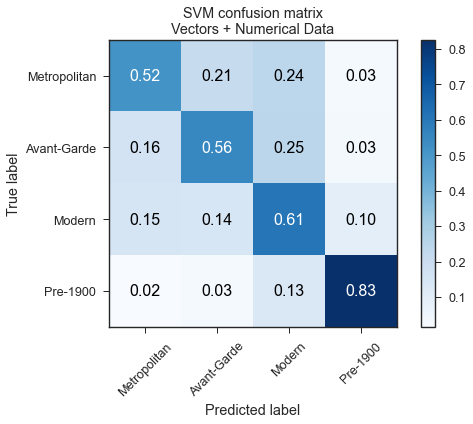

In [64]:
cm_svm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plot_confusion_matrix(cm_svm, classes,
                          normalize=True,
                          title='SVM confusion matrix\nVectors + Numerical Data',
                          cmap=plt.cm.Blues);

- Still overfit but a very good spread of predictions here compared to the other models. Each category is correctly predicted at least half the time, and Pre-1900 poetry is fairly easily recognized by the model.

#### Feature importances

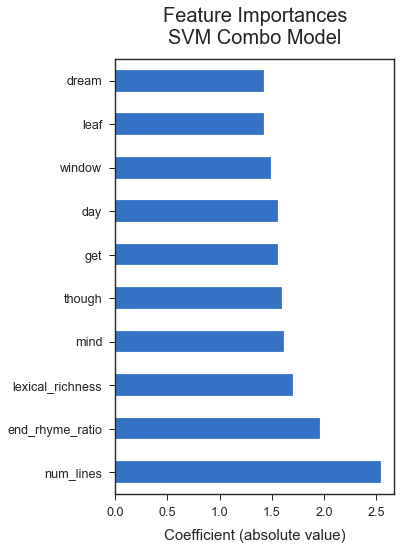

In [65]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- The top three spots are occupied by my engineered features. 
- Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Changing C value and class weight

⏰ NOTE: Next cell took me 10 minutes to run.

In [70]:
%%time

# instantiate the model
svm_combo2 = SVC(
#     C=2, 
    kernel='linear', 
    class_weight='balanced'
)

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 9min 51s, sys: 8.26 s, total: 10min
Wall time: 10min 25s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

⏰ NOTE: Next cell took me 10 minutes to run.

In [71]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9702786377708978
F1 score: 0.9702371733464628

-----TEST-----
Accuracy: 0.6267409470752089
F1 score: 0.6262380396362931

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.58      0.56       239
 avant_garde       0.58      0.55      0.56       268
      modern       0.58      0.56      0.57       311
    pre_1900       0.81      0.83      0.82       259

    accuracy                           0.63      1077
   macro avg       0.63      0.63      0.63      1077
weighted avg       0.63      0.63      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[138  51  44   6]
 [ 57 148  51  12]
 [ 57  49 174  31]
 [  5   8  31 215]]
CPU times: user 9min, sys: 3.83 s, total: 9min 4s
Wall time: 9min 5s


#### Confusion matrix

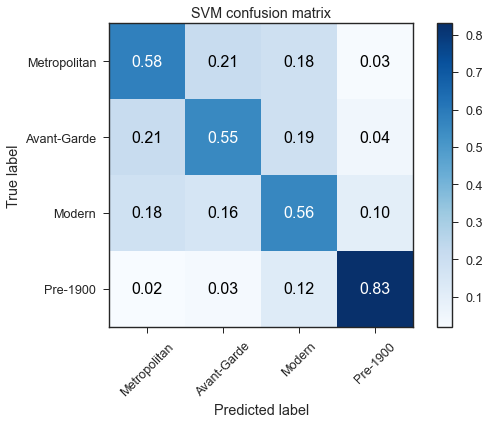

In [72]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

#### Feature importances

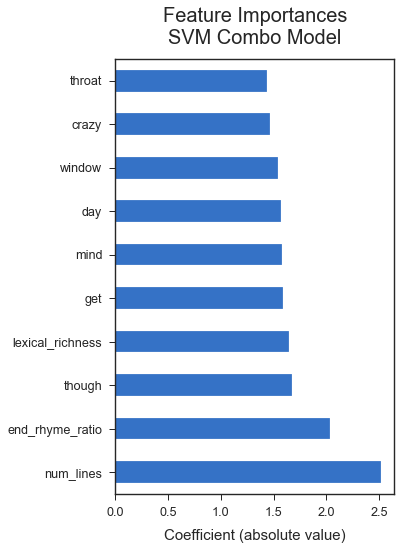

In [73]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

In [ ]:
from sklearn.svm import LinearSVC

In [78]:
%%time

# instantiate the model
svm_lin_combo = LinearSVC(
#     C=2, 
#     class_weight='balanced'
)

# fit to the training set
svm_lin_combo.fit(X_train_combo, y_train)

CPU times: user 24.7 s, sys: 1.57 s, total: 26.2 s
Wall time: 26.3 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [79]:
%%time

# predict class for the train and test sets
y_train_preds_svm_lin_combo = svm_lin_combo.predict(X_train_combo)
y_test_preds_svm_lin_combo = svm_lin_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_lin_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_lin_combo)
svm_lin_combo_f1_train = f1_score(y_train, y_train_preds_svm_lin_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_lin_combo_acc_train}')
print(f'F1 score: {svm_lin_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_lin_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_lin_combo)
svm_lin_combo_f1_test = f1_score(y_test, y_test_preds_svm_lin_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_lin_combo_acc_test}')
print(f'F1 score: {svm_lin_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_lin_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_lin_combo))

-----TRAIN-----
Accuracy: 0.9996904024767802
F1 score: 0.9996903889420556

-----TEST-----
Accuracy: 0.6239554317548747
F1 score: 0.620327641509353

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.56      0.51      0.53       239
 avant_garde       0.57      0.56      0.56       268
      modern       0.56      0.55      0.56       311
    pre_1900       0.79      0.88      0.83       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  54  52  10]
 [ 43 150  63  12]
 [ 51  51 172  37]
 [  4   8  20 227]]
CPU times: user 8.48 s, sys: 1.83 s, total: 10.3 s
Wall time: 9.33 s


#### Confusion matrix

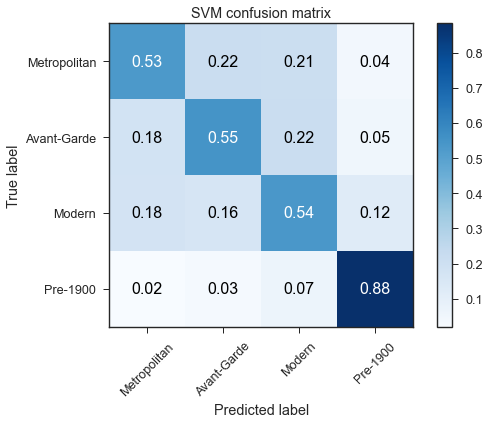

In [77]:
cm = confusion_matrix(y_test, y_test_preds_svm_lin_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

In [80]:
%%time

# instantiate random forest classifiers
svm_lin_vec = LinearSVC()
svm_lin_combo = LinearSVC()

# fit them to the training set and evaluate
cv_scores_svm_lin_vec = cross_val_score(
    svm_lin_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_lin_combo = cross_val_score(
    svm_lin_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_vec}')
print(f'Average score: {np.mean(cv_scores_svm_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_combo}')
print(f'Average score: {np.mean(cv_scores_svm_combo)}\n')

-----Vectors only-----
All scores: [0.57162223 0.65635489 0.56057759 0.60033056 0.596614   0.61479061
 0.5940823  0.60793209 0.62537091 0.55219607]
Average score: 0.5979871245353284

------Vectors + Numerical Data-----
All scores: [0.62463016 0.65362662 0.61669224 0.63429354 0.61232149 0.62227621
 0.60247644 0.64619977 0.65761514 0.59831745]
Average score: 0.6268449045483155

CPU times: user 3min 7s, sys: 3.81 s, total: 3min 11s
Wall time: 4min 47s


In [40]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [41]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 17.6 s, sys: 101 ms, total: 17.7 s
Wall time: 17.8 s


- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**